# Content Based Movie Clustering


#### By Harrison Baty

# Overview:
Research Questions: How can you use clustering techniques to achieve the following? Netflix wants to identify similar movies based on movie characteristics. After someone has finished a movie how can we recommend them a new one?

In [1]:
# Initializing the environment
!pip install umap-learn
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
import math
import seaborn as sns
from scipy import stats
from sklearn.manifold import TSNE
import umap
import time
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
import random

# import and read data
data = 'netflix_titles.csv'

raw_movie_data_df = pd.read_csv(data)

raw_movie_data_df.info()

raw_movie_data_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


# Data Cleaning/Exploration/Feature Engineering:
The data cleaning proceedure for the collected data ended up including getting rid of some rows which contain tv shows (we are only going to be looking at movies), splitting up some lists contained in single columns (for cast, genre, and country, As well as, creating dummy variables for genre, rating, and country to be used in our clustering algorithms.

In [59]:
raw_movie_data_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [2]:
# Looking at data types to understand changes that might need to be made
raw_movie_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [3]:
# Creating a new df with each cast member in a different column
cast_df = raw_movie_data_df['cast'].str.split(',', expand=True)

In [4]:
# Checking on the above new dataframe
cast_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,João Miguel,Bianca Comparato,Michel Gomes,Rodolfo Valente,Vaneza Oliveira,Rafael Lozano,Viviane Porto,Mel Fronckowiak,Sergio Mamberti,Zezé Motta,...,None,None,None,None,None,None,None,None,None,None
1,Demián Bichir,Héctor Bonilla,Oscar Serrano,Azalia Ortiz,Octavio Michel,Carmen Beato,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Tedd Chan,Stella Chung,Henley Hii,Lawrence Koh,Tommy Kuan,Josh Lai,Mark Lee,Susan Leong,Benjamin Lim,None,...,None,None,None,None,None,None,None,None,None,None
3,Elijah Wood,John C. Reilly,Jennifer Connelly,Christopher Plummer,Crispin Glover,Martin Landau,Fred Tatasciore,Alan Oppenheimer,Tom Kane,None,...,None,None,None,None,None,None,None,None,None,None
4,Jim Sturgess,Kevin Spacey,Kate Bosworth,Aaron Yoo,Liza Lapira,Jacob Pitts,Laurence Fishburne,Jack McGee,Josh Gad,Sam Golzari,...,None,None,None,None,None,None,None,None,None,None


In [5]:
# Adding the cast df to the original df
movie_data_df = pd.concat([raw_movie_data_df, cast_df], axis=1)


for i in range (5, 50):
  movie_data_df = movie_data_df.drop([i], axis=1)

movie_data_df = movie_data_df.drop(["cast"], axis=1)

In [6]:
#Changing the column names for the actors broken out
newlist = ['actor1', 'actor2', 'actor3', 'actor4', 'actor5',]

for i in range (11, 16):
  movie_data_df.columns.values[i] = newlist[i-11]

In [7]:
movie_data_df

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,description,actor1,actor2,actor3,actor4,actor5
0,s1,TV Show,3%,NaN,Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,João Miguel,Bianca Comparato,Michel Gomes,Rodolfo Valente,Vaneza Oliveira
1,s2,Movie,7:19,Jorge Michel Grau,Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,Demián Bichir,Héctor Bonilla,Oscar Serrano,Azalia Ortiz,Octavio Michel
2,s3,Movie,23:59,Gilbert Chan,Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",Tedd Chan,Stella Chung,Henley Hii,Lawrence Koh,Tommy Kuan
3,s4,Movie,9,Shane Acker,United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",Elijah Wood,John C. Reilly,Jennifer Connelly,Christopher Plummer,Crispin Glover
4,s5,Movie,21,Robert Luketic,United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,Jim Sturgess,Kevin Spacey,Kate Bosworth,Aaron Yoo,Liza Lapira
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7782,s7783,Movie,Zozo,Josef Fares,"Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...,Imad Creidi,Antoinette Turk,Elias Gergi,Carmen Lebbos,Viktor Axelsson
7783,s7784,Movie,Zubaan,Mozez Singh,India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,Vicky Kaushal,Sarah-Jane Dias,Raaghav Chanana,Manish Chaudhary,Meghna Malik
7784,s7785,Movie,Zulu Man in Japan,NaN,NaN,"September 25, 2020",2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast...",Nasty C,None,None,None,None
7785,s7786,TV Show,Zumbo's Just Desserts,NaN,Australia,"October 31, 2020",2019,TV-PG,1 Season,"International TV Shows, Reality TV",Dessert wizard Adriano Zumbo looks for the nex...,Adriano Zumbo,Rachel Khoo,None,None,None


In [8]:
# Dropping tv shows from our data because we are just trying to cluster movies for this project
movie_data_df = movie_data_df[movie_data_df['type'] == 'Movie']

# Checking the decrease in rows
movie_data_df.shape
length = len(movie_data_df)

In [9]:
# Looking at the number of unique directors in the list. After seeing how many different directors there are it wouldn't be possible to use dummy variables. we are going to drop director from the data.
movie_data_df['director'].nunique()

3909

In [10]:
# Dropping director and date_added from the data
movie_data_df = movie_data_df.drop(['director', 'date_added'], axis=1)

In [11]:
# Creating a new df with the first country in a single column and then concat onto the main df
# New df with all the countries from the old column split up into different columns
new_country_df = movie_data_df['country'].str.split(',', expand=True)

# New df keeping just the primary country
country_df = new_country_df[[0]].copy()

# Adding the new df to the main df
movie_data_df = pd.concat([movie_data_df, country_df], axis=1)

In [12]:
# Removing the old contry column
movie_data_df = movie_data_df.drop(['country'], axis=1)

movie_data_df.head()

,show_id,type,title,release_year,rating,duration,listed_in,description,actor1,actor2,actor3,actor4,actor5,0
1,s2,Movie,7:19,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,Demián Bichir,Héctor Bonilla,Oscar Serrano,Azalia Ortiz,Octavio Michel,Mexico
2,s3,Movie,23:59,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",Tedd Chan,Stella Chung,Henley Hii,Lawrence Koh,Tommy Kuan,Singapore
3,s4,Movie,9,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",Elijah Wood,John C. Reilly,Jennifer Connelly,Christopher Plummer,Crispin Glover,United States
4,s5,Movie,21,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,Jim Sturgess,Kevin Spacey,Kate Bosworth,Aaron Yoo,Liza Lapira,United States
6,s7,Movie,122,2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",Amina Khalil,Ahmed Dawood,Tarek Lotfy,Ahmed El Fishawy,Mahmoud Hijazi,Egypt


In [13]:
# Rename '0' (new country column) to 'country'
movie_data_df = movie_data_df.rename(columns={0: "country"})

In [14]:
movie_data_df.head()

,show_id,type,title,release_year,rating,duration,listed_in,description,actor1,actor2,actor3,actor4,actor5,country
1,s2,Movie,7:19,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,Demián Bichir,Héctor Bonilla,Oscar Serrano,Azalia Ortiz,Octavio Michel,Mexico
2,s3,Movie,23:59,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",Tedd Chan,Stella Chung,Henley Hii,Lawrence Koh,Tommy Kuan,Singapore
3,s4,Movie,9,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",Elijah Wood,John C. Reilly,Jennifer Connelly,Christopher Plummer,Crispin Glover,United States
4,s5,Movie,21,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,Jim Sturgess,Kevin Spacey,Kate Bosworth,Aaron Yoo,Liza Lapira,United States
6,s7,Movie,122,2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",Amina Khalil,Ahmed Dawood,Tarek Lotfy,Ahmed El Fishawy,Mahmoud Hijazi,Egypt


In [15]:
# Thinking about mainly using rating and genre for the recommendation. Dummies for each should work after I remove all but the primary genre from that column:
# Creating new df with just the "listed_in" genres 
new_genre_df = movie_data_df['listed_in'].str.split(',', expand=True)

# New df with just the primary genre
genre_df = new_genre_df[[0]].copy()

# Adding back to the main df
movie_data_df = pd.concat([movie_data_df, genre_df], axis=1)

movie_data_df

,show_id,type,title,release_year,rating,duration,listed_in,description,actor1,actor2,actor3,actor4,actor5,country,0
1,s2,Movie,7:19,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,Demián Bichir,Héctor Bonilla,Oscar Serrano,Azalia Ortiz,Octavio Michel,Mexico,Dramas
2,s3,Movie,23:59,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",Tedd Chan,Stella Chung,Henley Hii,Lawrence Koh,Tommy Kuan,Singapore,Horror Movies
3,s4,Movie,9,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",Elijah Wood,John C. Reilly,Jennifer Connelly,Christopher Plummer,Crispin Glover,United States,Action & Adventure
4,s5,Movie,21,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,Jim Sturgess,Kevin Spacey,Kate Bosworth,Aaron Yoo,Liza Lapira,United States,Dramas
6,s7,Movie,122,2019,TV-MA,95 min,"Horror Movies, International Movies","After an awful accident, a couple admitted to ...",Amina Khalil,Ahmed Dawood,Tarek Lotfy,Ahmed El Fishawy,Mahmoud Hijazi,Egypt,Horror Movies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,s7782,Movie,Zoom,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",Tim Allen,Courteney Cox,Chevy Chase,Kate Mara,Ryan Newman,United States,Children & Family Movies
7782,s7783,Movie,Zozo,2005,TV-MA,99 min,"Dramas, International Movies",When Lebanon's Civil War deprives Zozo of his ...,Imad Creidi,Antoinette Turk,Elias Gergi,Carmen Lebbos,Viktor Axelsson,Sweden,Dramas
7783,s7784,Movie,Zubaan,2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,Vicky Kaushal,Sarah-Jane Dias,Raaghav Chanana,Manish Chaudhary,Meghna Malik,India,Dramas
7784,s7785,Movie,Zulu Man in Japan,2019,TV-MA,44 min,"Documentaries, International Movies, Music & M...","In this documentary, South African rapper Nast...",Nasty C,None,None,None,None,NaN,Documentaries


In [16]:
# Renaming the column to "genre"
movie_data_df = movie_data_df.rename(columns={0:"genre"})

# Removing the old contry column
movie_data_df = movie_data_df.drop(['listed_in'], axis=1)

movie_data_df

,show_id,type,title,release_year,rating,duration,description,actor1,actor2,actor3,actor4,actor5,country,genre
1,s2,Movie,7:19,2016,TV-MA,93 min,After a devastating earthquake hits Mexico Cit...,Demián Bichir,Héctor Bonilla,Oscar Serrano,Azalia Ortiz,Octavio Michel,Mexico,Dramas
2,s3,Movie,23:59,2011,R,78 min,"When an army recruit is found dead, his fellow...",Tedd Chan,Stella Chung,Henley Hii,Lawrence Koh,Tommy Kuan,Singapore,Horror Movies
3,s4,Movie,9,2009,PG-13,80 min,"In a postapocalyptic world, rag-doll robots hi...",Elijah Wood,John C. Reilly,Jennifer Connelly,Christopher Plummer,Crispin Glover,United States,Action & Adventure
4,s5,Movie,21,2008,PG-13,123 min,A brilliant group of students become card-coun...,Jim Sturgess,Kevin Spacey,Kate Bosworth,Aaron Yoo,Liza Lapira,United States,Dramas
6,s7,Movie,122,2019,TV-MA,95 min,"After an awful accident, a couple admitted to ...",Amina Khalil,Ahmed Dawood,Tarek Lotfy,Ahmed El Fishawy,Mahmoud Hijazi,Egypt,Horror Movies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,s7782,Movie,Zoom,2006,PG,88 min,"Dragged from civilian life, a former superhero...",Tim Allen,Courteney Cox,Chevy Chase,Kate Mara,Ryan Newman,United States,Children & Family Movies
7782,s7783,Movie,Zozo,2005,TV-MA,99 min,When Lebanon's Civil War deprives Zozo of his ...,Imad Creidi,Antoinette Turk,Elias Gergi,Carmen Lebbos,Viktor Axelsson,Sweden,Dramas
7783,s7784,Movie,Zubaan,2015,TV-14,111 min,A scrappy but poor boy worms his way into a ty...,Vicky Kaushal,Sarah-Jane Dias,Raaghav Chanana,Manish Chaudhary,Meghna Malik,India,Dramas
7784,s7785,Movie,Zulu Man in Japan,2019,TV-MA,44 min,"In this documentary, South African rapper Nast...",Nasty C,None,None,None,None,NaN,Documentaries


In [17]:
# Getting dummy variables for rating
rating_dummy_df = pd.get_dummies(movie_data_df["rating"])

# Getting dummy variables for genre
genre_dummy_df = pd.get_dummies(movie_data_df["genre"])

# Getting dummy variables for country
country_dummy_df = pd.get_dummies(movie_data_df["country"])


In [18]:
# Adding dummies back to the main df
movie_data_df = pd.concat([movie_data_df, rating_dummy_df, genre_dummy_df, country_dummy_df], axis=1)

movie_data_df

,show_id,type,title,release_year,rating,duration,description,actor1,actor2,actor3,...,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,Vietnam,West Germany,Zimbabwe
1,s2,Movie,7:19,2016,TV-MA,93 min,After a devastating earthquake hits Mexico Cit...,Demián Bichir,Héctor Bonilla,Oscar Serrano,...,0,0,0,0,0,0,0,0,0,0
2,s3,Movie,23:59,2011,R,78 min,"When an army recruit is found dead, his fellow...",Tedd Chan,Stella Chung,Henley Hii,...,0,0,0,0,0,0,0,0,0,0
3,s4,Movie,9,2009,PG-13,80 min,"In a postapocalyptic world, rag-doll robots hi...",Elijah Wood,John C. Reilly,Jennifer Connelly,...,0,0,0,0,1,0,0,0,0,0
4,s5,Movie,21,2008,PG-13,123 min,A brilliant group of students become card-coun...,Jim Sturgess,Kevin Spacey,Kate Bosworth,...,0,0,0,0,1,0,0,0,0,0
6,s7,Movie,122,2019,TV-MA,95 min,"After an awful accident, a couple admitted to ...",Amina Khalil,Ahmed Dawood,Tarek Lotfy,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,s7782,Movie,Zoom,2006,PG,88 min,"Dragged from civilian life, a former superhero...",Tim Allen,Courteney Cox,Chevy Chase,...,0,0,0,0,1,0,0,0,0,0
7782,s7783,Movie,Zozo,2005,TV-MA,99 min,When Lebanon's Civil War deprives Zozo of his ...,Imad Creidi,Antoinette Turk,Elias Gergi,...,0,0,0,0,0,0,0,0,0,0
7783,s7784,Movie,Zubaan,2015,TV-14,111 min,A scrappy but poor boy worms his way into a ty...,Vicky Kaushal,Sarah-Jane Dias,Raaghav Chanana,...,0,0,0,0,0,0,0,0,0,0
7784,s7785,Movie,Zulu Man in Japan,2019,TV-MA,44 min,"In this documentary, South African rapper Nast...",Nasty C,None,None,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Returning the list of columns with a null value, not sure why I wanted to use a function but I did...
def return_columns_with_null(df):
  return df.columns[df.isnull().any()]

return_columns_with_null(movie_data_df)

Index(['rating', 'actor1', 'actor2', 'actor3', 'actor4', 'actor5', 'country'], dtype='object')

In [20]:
# Creating a new column in the df for a number to represent the different ratings. Note, none of these should remain as zeros if everything works in the next cell.
movie_data_df.insert(5, "rating_class", 0)

In [21]:
# Checking that my rating_class idea will work as expected
print(movie_data_df.iloc[1]["rating"]=="R")

True


In [22]:
# Creating a "rating_class" numeric column to be used in the model rather than dummies for features
# Making a dictionary for the "rating" (string) to "rating_class" (numeric) conversion
ratingconversiondict = {
    "TV-Y": 1,
    "TV-Y7-FV": 2,
    "TV-Y7": 2,
    "TV-G": 3,
    "G": 3,
    "UR": 4,
    "NR": 4,
    "TV-PG": 5,
    "PG": 5,
    "TV-14": 6,
    "PG-13": 6,
    "TV-MA": 7,
    "R": 7,
    "NC-17": 8
}

# Using .map and the above dictionary to set "rating_class" column with the existing "rating" column
movie_data_df["rating_class"] = movie_data_df["rating"].map(ratingconversiondict)
movie_data_df

,show_id,type,title,release_year,rating,rating_class,duration,description,actor1,actor2,...,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,Vietnam,West Germany,Zimbabwe
1,s2,Movie,7:19,2016,TV-MA,7.0,93 min,After a devastating earthquake hits Mexico Cit...,Demián Bichir,Héctor Bonilla,...,0,0,0,0,0,0,0,0,0,0
2,s3,Movie,23:59,2011,R,7.0,78 min,"When an army recruit is found dead, his fellow...",Tedd Chan,Stella Chung,...,0,0,0,0,0,0,0,0,0,0
3,s4,Movie,9,2009,PG-13,6.0,80 min,"In a postapocalyptic world, rag-doll robots hi...",Elijah Wood,John C. Reilly,...,0,0,0,0,1,0,0,0,0,0
4,s5,Movie,21,2008,PG-13,6.0,123 min,A brilliant group of students become card-coun...,Jim Sturgess,Kevin Spacey,...,0,0,0,0,1,0,0,0,0,0
6,s7,Movie,122,2019,TV-MA,7.0,95 min,"After an awful accident, a couple admitted to ...",Amina Khalil,Ahmed Dawood,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,s7782,Movie,Zoom,2006,PG,5.0,88 min,"Dragged from civilian life, a former superhero...",Tim Allen,Courteney Cox,...,0,0,0,0,1,0,0,0,0,0
7782,s7783,Movie,Zozo,2005,TV-MA,7.0,99 min,When Lebanon's Civil War deprives Zozo of his ...,Imad Creidi,Antoinette Turk,...,0,0,0,0,0,0,0,0,0,0
7783,s7784,Movie,Zubaan,2015,TV-14,6.0,111 min,A scrappy but poor boy worms his way into a ty...,Vicky Kaushal,Sarah-Jane Dias,...,0,0,0,0,0,0,0,0,0,0
7784,s7785,Movie,Zulu Man in Japan,2019,TV-MA,7.0,44 min,"In this documentary, South African rapper Nast...",Nasty C,None,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Descriptive statistics for just text-based variables
movie_data_df.describe(include=['O'])

,show_id,type,title,rating,duration,description,actor1,actor2,actor3,actor4,actor5,country,genre
count,5377,5377,5377,5372,5377,5377,4951,4348,4244,4148,4001,5147,5377
unique,5377,1,5377,14,201,5363,3363,3438,3548,3636,3557,74,19
top,s5351,Movie,The Devil Inside,TV-MA,90 min,A surly septuagenarian gets another chance at ...,Shah Rukh Khan,Kareena Kapoor,Jackie Shroff,Andrea Libman,Anupam Kher,United States,Dramas
freq,1,5377,1,1845,136,3,27,13,8,9,8,2100,1384


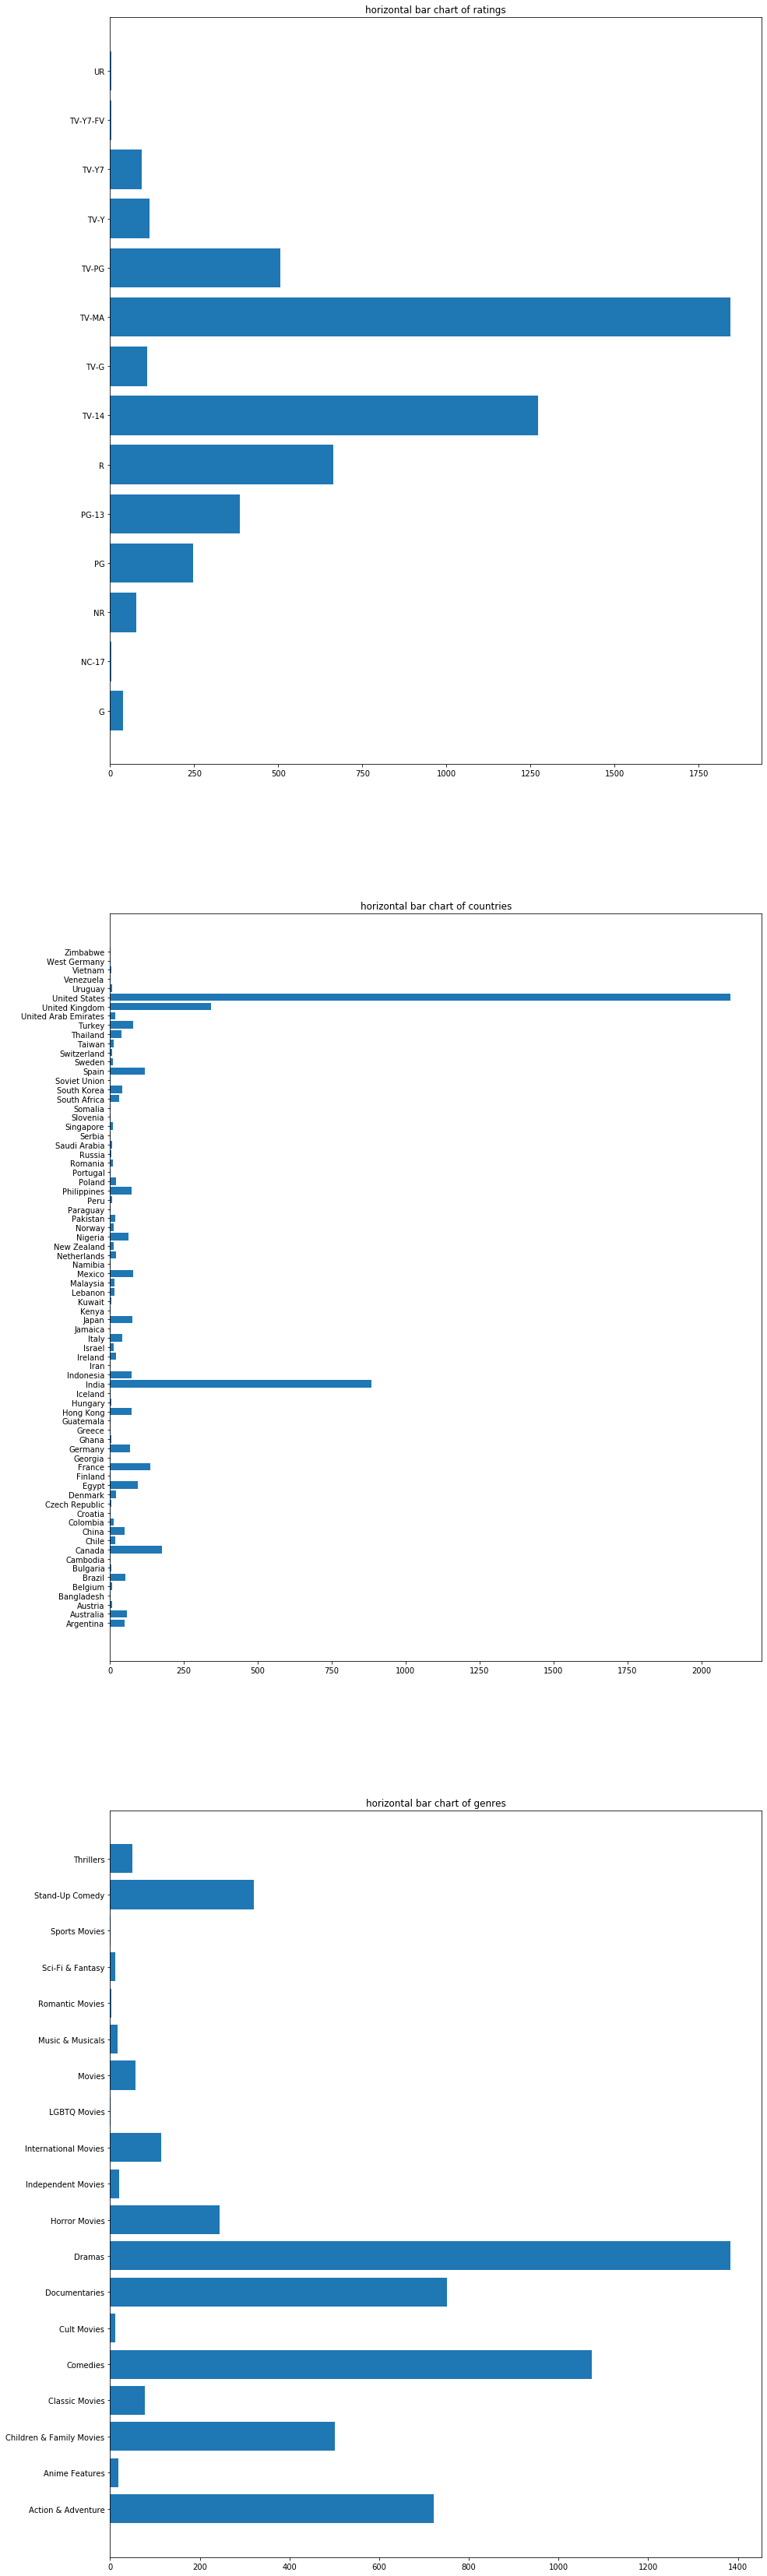

In [24]:
# Bar chart for frequency of different ratings, countries, and genres
plt.figure(figsize=(15,60))

# Rating:
plt.subplot(3,1,1)
plt.barh(movie_data_df.groupby("rating")["rating"].count().index, 
        movie_data_df.groupby("rating")["rating"].count())
plt.title("horizontal bar chart of ratings")

# Country:
plt.subplot(3,1,2)
plt.barh(movie_data_df.groupby("country")["country"].count().index, 
        movie_data_df.groupby("country")["country"].count()) 
plt.title("horizontal bar chart of countries")

# Genre:
plt.subplot(3,1,3)
plt.barh(movie_data_df.groupby("genre")["genre"].count().index, 
        movie_data_df.groupby("genre")["genre"].count()) 
plt.title("horizontal bar chart of genres")

plt.show()

Text(0.5, 1.0, 'horizontal bar chart of ratings')

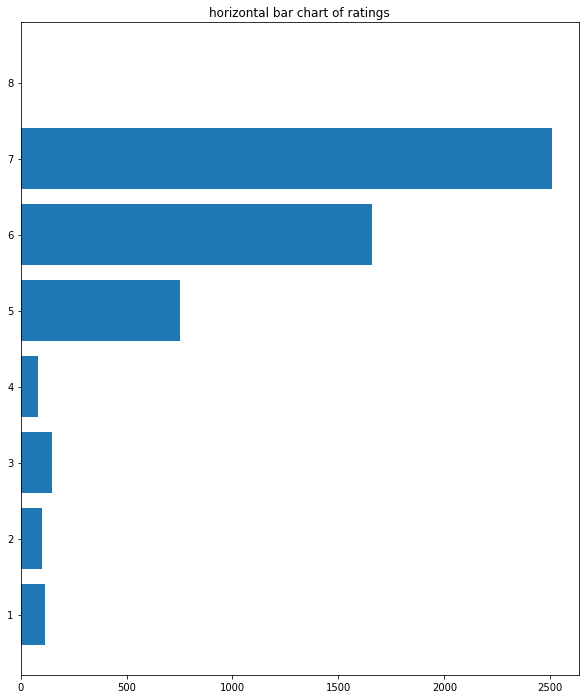

In [25]:
plt.figure(figsize=(10,12))

# plotting "rating_class" because I think we have some nan that shouldn't be there:

plt.barh(movie_data_df.groupby("rating_class")["rating_class"].count().index, 
        movie_data_df.groupby("rating_class")["rating_class"].count())
plt.title("horizontal bar chart of ratings")



After looking at the above visualizations I realized that something wasn't working right with 'rating_class'. The below works on that.

In [26]:
# Checking for na values in 'rating_class'
movie_data_df['rating_class'].isna().sum()

5

In [27]:
# Looking at the number of movies in each rating class vs the actual rating amounts
print(movie_data_df['rating_class'].value_counts())

7.0    2508
6.0    1658
5.0     752
3.0     150
1.0     117
2.0     100
4.0      84
8.0       3
Name: rating_class, dtype: int64


In [28]:
print(movie_data_df['rating'].value_counts())

TV-MA       1845
TV-14       1272
R            663
TV-PG        505
PG-13        386
PG           247
TV-Y         117
TV-G         111
TV-Y7         95
NR            79
G             39
TV-Y7-FV       5
UR             5
NC-17          3
Name: rating, dtype: int64


In [29]:
# Found the last missing rows and decided to leave them out. They look like tv/comedy specials which I don't mind losing for the initial training.
bool1 = pd.isnull(movie_data_df['rating_class'])
nan_dataframe = movie_data_df[bool1]
nan_dataframe.head(5)

,show_id,type,title,release_year,rating,rating_class,duration,description,actor1,actor2,...,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,Vietnam,West Germany,Zimbabwe
67,s68,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,2017,NaN,NaN,37 min,Oprah Winfrey sits down with director Ava DuVe...,Oprah Winfrey,Ava DuVernay,...,0,0,0,0,0,0,0,0,0,0
3736,s3737,Movie,Louis C.K. 2017,2017,NaN,NaN,74 min,"Louis C.K. muses on religion, eternal love, gi...",Louis C.K.,None,...,0,0,0,0,1,0,0,0,0,0
3737,s3738,Movie,Louis C.K.: Hilarious,2010,NaN,NaN,84 min,Emmy-winning comedy writer Louis C.K. brings h...,Louis C.K.,None,...,0,0,0,0,1,0,0,0,0,0
3738,s3739,Movie,Louis C.K.: Live at the Comedy Store,2015,NaN,NaN,66 min,The comic puts his trademark hilarious/thought...,Louis C.K.,None,...,0,0,0,0,1,0,0,0,0,0
4323,s4324,Movie,My Honor Was Loyalty,2015,NaN,NaN,115 min,"Amid the chaos and horror of World War II, a c...",Leone Frisa,Paolo Vaccarino,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Created new boolean list of not null rows for the final df.
bool2 = pd.notna(movie_data_df['rating_class'])
not_nan_df = movie_data_df[bool2]

In [31]:
# Clean data for training
movie_data_df = not_nan_df
movie_data_df

,show_id,type,title,release_year,rating,rating_class,duration,description,actor1,actor2,...,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,Vietnam,West Germany,Zimbabwe
1,s2,Movie,7:19,2016,TV-MA,7.0,93 min,After a devastating earthquake hits Mexico Cit...,Demián Bichir,Héctor Bonilla,...,0,0,0,0,0,0,0,0,0,0
2,s3,Movie,23:59,2011,R,7.0,78 min,"When an army recruit is found dead, his fellow...",Tedd Chan,Stella Chung,...,0,0,0,0,0,0,0,0,0,0
3,s4,Movie,9,2009,PG-13,6.0,80 min,"In a postapocalyptic world, rag-doll robots hi...",Elijah Wood,John C. Reilly,...,0,0,0,0,1,0,0,0,0,0
4,s5,Movie,21,2008,PG-13,6.0,123 min,A brilliant group of students become card-coun...,Jim Sturgess,Kevin Spacey,...,0,0,0,0,1,0,0,0,0,0
6,s7,Movie,122,2019,TV-MA,7.0,95 min,"After an awful accident, a couple admitted to ...",Amina Khalil,Ahmed Dawood,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,s7782,Movie,Zoom,2006,PG,5.0,88 min,"Dragged from civilian life, a former superhero...",Tim Allen,Courteney Cox,...,0,0,0,0,1,0,0,0,0,0
7782,s7783,Movie,Zozo,2005,TV-MA,7.0,99 min,When Lebanon's Civil War deprives Zozo of his ...,Imad Creidi,Antoinette Turk,...,0,0,0,0,0,0,0,0,0,0
7783,s7784,Movie,Zubaan,2015,TV-14,6.0,111 min,A scrappy but poor boy worms his way into a ty...,Vicky Kaushal,Sarah-Jane Dias,...,0,0,0,0,0,0,0,0,0,0
7784,s7785,Movie,Zulu Man in Japan,2019,TV-MA,7.0,44 min,"In this documentary, South African rapper Nast...",Nasty C,None,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Resetting index and dropping old
movie_data_df = movie_data_df.reset_index(drop=True)
movie_data_df

,show_id,type,title,release_year,rating,rating_class,duration,description,actor1,actor2,...,Thailand,Turkey,United Arab Emirates,United Kingdom,United States,Uruguay,Venezuela,Vietnam,West Germany,Zimbabwe
0,s2,Movie,7:19,2016,TV-MA,7.0,93 min,After a devastating earthquake hits Mexico Cit...,Demián Bichir,Héctor Bonilla,...,0,0,0,0,0,0,0,0,0,0
1,s3,Movie,23:59,2011,R,7.0,78 min,"When an army recruit is found dead, his fellow...",Tedd Chan,Stella Chung,...,0,0,0,0,0,0,0,0,0,0
2,s4,Movie,9,2009,PG-13,6.0,80 min,"In a postapocalyptic world, rag-doll robots hi...",Elijah Wood,John C. Reilly,...,0,0,0,0,1,0,0,0,0,0
3,s5,Movie,21,2008,PG-13,6.0,123 min,A brilliant group of students become card-coun...,Jim Sturgess,Kevin Spacey,...,0,0,0,0,1,0,0,0,0,0
4,s7,Movie,122,2019,TV-MA,7.0,95 min,"After an awful accident, a couple admitted to ...",Amina Khalil,Ahmed Dawood,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5367,s7782,Movie,Zoom,2006,PG,5.0,88 min,"Dragged from civilian life, a former superhero...",Tim Allen,Courteney Cox,...,0,0,0,0,1,0,0,0,0,0
5368,s7783,Movie,Zozo,2005,TV-MA,7.0,99 min,When Lebanon's Civil War deprives Zozo of his ...,Imad Creidi,Antoinette Turk,...,0,0,0,0,0,0,0,0,0,0
5369,s7784,Movie,Zubaan,2015,TV-14,6.0,111 min,A scrappy but poor boy worms his way into a ty...,Vicky Kaushal,Sarah-Jane Dias,...,0,0,0,0,0,0,0,0,0,0
5370,s7785,Movie,Zulu Man in Japan,2019,TV-MA,7.0,44 min,"In this documentary, South African rapper Nast...",Nasty C,None,...,0,0,0,0,0,0,0,0,0,0


In [33]:
for i in movie_data_df.columns:
    print(i)

show_id
type
title
release_year
rating
rating_class
duration
description
actor1
actor2
actor3
actor4
actor5
country
genre
G
NC-17
NR
PG
PG-13
R
TV-14
TV-G
TV-MA
TV-PG
TV-Y
TV-Y7
TV-Y7-FV
UR
Action & Adventure
Anime Features
Children & Family Movies
Classic Movies
Comedies
Cult Movies
Documentaries
Dramas
Horror Movies
Independent Movies
International Movies
LGBTQ Movies
Movies
Music & Musicals
Romantic Movies
Sci-Fi & Fantasy
Sports Movies
Stand-Up Comedy
Thrillers
Argentina
Australia
Austria
Bangladesh
Belgium
Brazil
Bulgaria
Cambodia
Canada
Chile
China
Colombia
Croatia
Czech Republic
Denmark
Egypt
Finland
France
Georgia
Germany
Ghana
Greece
Guatemala
Hong Kong
Hungary
Iceland
India
Indonesia
Iran
Ireland
Israel
Italy
Jamaica
Japan
Kenya
Kuwait
Lebanon
Malaysia
Mexico
Namibia
Netherlands
New Zealand
Nigeria
Norway
Pakistan
Paraguay
Peru
Philippines
Poland
Portugal
Romania
Russia
Saudi Arabia
Serbia
Singapore
Slovenia
Somalia
South Africa
South Korea
Soviet Union
Spain
Sweden
Switzerla

# Model Creation:
Now with some finalized data for the movies I am going to train several clustering models to place each movie into a group with other similar movies. For this I use KMeans and DBSCAN clustering

## Trying to cluster with all dummy variables first

Using the dummy variables for rating, country, and genre as features for fitting our clusters.

In [34]:
# Using the all dummy feature 
X_all_dummy = movie_data_df.drop(['show_id', 'type', 'title', 'release_year', 'rating', 'rating_class', 'duration', 'description', 'actor1', 'actor2', 'actor3', 'actor4', 'actor5', 'country', 'genre'], axis=1)

In [35]:
# Using PCA to reduce the feature set for training and visualization
X_dummy_pca = PCA(n_components=.95).fit_transform(X_all_dummy)

### KMeans:

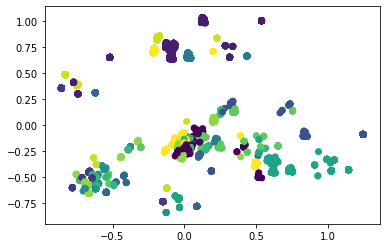

Silhouette score for the all dummy pca 13 cluster k-means: 0.22593916478705503
The clusters found are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


,title,rating,genre,kmean_alldummy_group
0,7:19,TV-MA,Dramas,1
1,23:59,R,Horror Movies,10
2,9,PG-13,Action & Adventure,8
3,21,PG-13,Dramas,8
4,122,TV-MA,Horror Movies,1
...,...,...,...,...
5367,Zoom,PG,Children & Family Movies,6
5368,Zozo,TV-MA,Dramas,1
5369,Zubaan,TV-14,Dramas,3
5370,Zulu Man in Japan,TV-MA,Documentaries,12


In [36]:
kmeans = KMeans(n_clusters=13, random_state=234)

kmeans.fit(X_dummy_pca)

kmean_y_pred = kmeans.predict(X_dummy_pca)

# Plot the solution.
plt.scatter(X_dummy_pca[:,0], X_dummy_pca[:,1], c=kmean_y_pred)
plt.show()

print("Silhouette score for the all dummy pca 13 cluster k-means: {}".format(
    metrics.silhouette_score(X_all_dummy, kmean_y_pred, metric='euclidean')))

print("The clusters found are: {}".format(np.unique((kmean_y_pred))))

# Adding the group predictions to a df to take a look at
kmean_y_pred_df = pd.DataFrame(kmean_y_pred, columns=['kmean_alldummy_group'])
kmean_y_pred_df

# Adding the group predictions to a final predictions df for evaluation with the rest of the clustering methods 
movie_predictions_df = pd.concat([movie_data_df, kmean_y_pred_df], axis=1)

# Keeping just title, rating, genre, and predicted group for evaluation
movie_predictions_df = movie_predictions_df[['title', 'rating', 'genre', 'kmean_alldummy_group']]
movie_predictions_df


In [37]:
# Using the elbow method with distortion for different k values

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 30)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_dummy_pca)
    kmeanModel.fit(X_dummy_pca)
 
    distortions.append(sum(np.min(cdist(X_dummy_pca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_dummy_pca.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X_dummy_pca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_dummy_pca.shape[0]
    mapping2[k] = kmeanModel.inertia_

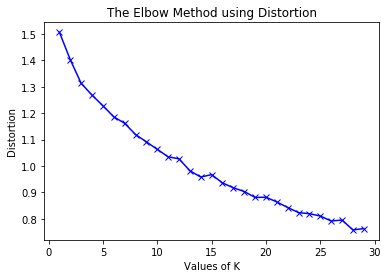

In [38]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# it looks like as k starts to flatten in the teens and more so once it hits 21. I will try different values and look at the resulting groups to decide.

### DBSCAN:

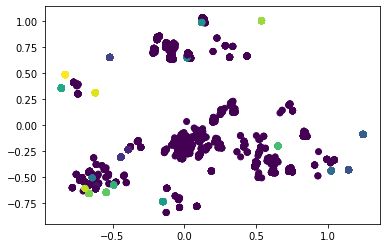

Silhouette score for pca all dummy DBSCAN: 0.17863306250554067
The clusters found are: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


,title,rating,genre,kmean_alldummy_group,DBSCAN_alldummy_group
0,7:19,TV-MA,Dramas,1,-1
1,23:59,R,Horror Movies,10,-1
2,9,PG-13,Action & Adventure,8,0
3,21,PG-13,Dramas,8,1
4,122,TV-MA,Horror Movies,1,-1
...,...,...,...,...,...
5367,Zoom,PG,Children & Family Movies,6,17
5368,Zozo,TV-MA,Dramas,1,9
5369,Zubaan,TV-14,Dramas,3,5
5370,Zulu Man in Japan,TV-MA,Documentaries,12,-1


In [39]:
# It looks like this method didn't fit the data into very equal groups but instead one main group with lots of smaller groups which doesn't reflect the distribution of the data

dbscan = DBSCAN(eps=0.6, min_samples=50)

dbscan_y_pred = dbscan.fit_predict(X_dummy_pca)

# Plot the solution.
plt.scatter(X_dummy_pca[:,0], X_dummy_pca[:,1], c=dbscan_y_pred)
plt.show()

print("Silhouette score for pca all dummy DBSCAN: {}".format(
    metrics.silhouette_score(X_all_dummy, dbscan_y_pred, metric='euclidean')))

print("The clusters found are: {}".format(np.unique(dbscan_y_pred)))

# Adding the group predictions to a df to take a look at
dbscan_y_pred_df = pd.DataFrame(dbscan_y_pred, columns=['DBSCAN_alldummy_group'])

# Adding the group predictions to a final predictions df for evaluation with the rest of the clustering methods 
movie_predictions_df = pd.concat([movie_predictions_df, dbscan_y_pred_df], axis=1)

movie_predictions_df

## Trying to cluster with the new "rating_class" feature and the rest of the dummies

In [40]:
# Trying the same clusters but with the continues "rating_class" column instead of the "rating" dummies
X_partial_dummy = movie_data_df.drop(['show_id','type','title','release_year','rating','duration','description','actor1','actor2','actor3','actor4','actor5','country','genre','G','NC-17','NR','PG','PG-13','R','TV-14','TV-G','TV-MA','TV-PG','TV-Y','TV-Y7','TV-Y7-FV','UR'], axis=1)

In [41]:
# Standardizing and then fit_transforming to 2 PCAs
scaler = StandardScaler()
X_partial_dummy_std = scaler.fit_transform(X_partial_dummy)

X_partial_dummy_std_pca = PCA(n_components=3).fit_transform(X_partial_dummy_std)

### KMeans:

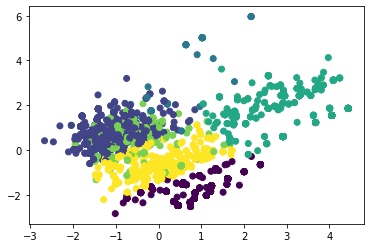

Silhouette score for the pca partical dummy 6 cluster k-means: 0.458655986301381
The clusters found are: [0 1 2 3 4 5]


,title,rating,genre,kmean_alldummy_group,DBSCAN_alldummy_group,kmean_partialdummy_group
0,7:19,TV-MA,Dramas,1,-1,1
1,23:59,R,Horror Movies,10,-1,5
2,9,PG-13,Action & Adventure,8,0,4
3,21,PG-13,Dramas,8,1,5
4,122,TV-MA,Horror Movies,1,-1,5
...,...,...,...,...,...,...
5367,Zoom,PG,Children & Family Movies,6,17,3
5368,Zozo,TV-MA,Dramas,1,9,5
5369,Zubaan,TV-14,Dramas,3,5,1
5370,Zulu Man in Japan,TV-MA,Documentaries,12,-1,5


In [42]:
kmeans = KMeans(n_clusters=6, random_state=234)

kmeans.fit(X_partial_dummy_std_pca)

kmean_y_pred = kmeans.predict(X_partial_dummy_std_pca)

# Plot the solution.
plt.scatter(X_partial_dummy_std_pca[:,0], X_partial_dummy_std_pca[:,1], c=kmean_y_pred)
plt.show()

print("Silhouette score for the pca partical dummy 6 cluster k-means: {}".format(
    metrics.silhouette_score(X_partial_dummy_std_pca, kmean_y_pred, metric='euclidean')))

print("The clusters found are: {}".format(np.unique((kmean_y_pred))))

# Adding the group predictions to a df to take a look at
kmean_y_pred_df2 = pd.DataFrame(kmean_y_pred, columns=['kmean_partialdummy_group'])

# Adding the group predictions to a final predictions df for evaluation with the rest of the clustering methods 
movie_predictions_df = pd.concat([movie_predictions_df, kmean_y_pred_df2], axis=1)

movie_predictions_df

In [43]:
# Using the elbow method with distortion for different k values

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 30)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_partial_dummy_std_pca)
    kmeanModel.fit(X_partial_dummy_std_pca)
 
    distortions.append(sum(np.min(cdist(X_partial_dummy_std_pca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_partial_dummy_std_pca.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X_partial_dummy_std_pca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_partial_dummy_std_pca.shape[0]
    mapping2[k] = kmeanModel.inertia_

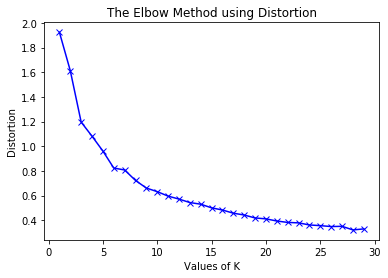

In [44]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# This graph of the distortions for different k values seems show a strong bend at k=6 which I will use for this method.

### DBSCAN:

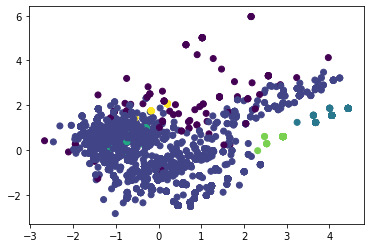

Silhouette score for the pca partical dummy DBSCAN: 0.2872691021010253
The clusters found are: [-1  0  1  2  3  4]


,title,rating,genre,kmean_alldummy_group,DBSCAN_alldummy_group,kmean_partialdummy_group,DBSCAN_partialdummy_group
0,7:19,TV-MA,Dramas,1,-1,1,0
1,23:59,R,Horror Movies,10,-1,5,0
2,9,PG-13,Action & Adventure,8,0,4,0
3,21,PG-13,Dramas,8,1,5,0
4,122,TV-MA,Horror Movies,1,-1,5,0
...,...,...,...,...,...,...,...
5367,Zoom,PG,Children & Family Movies,6,17,3,3
5368,Zozo,TV-MA,Dramas,1,9,5,0
5369,Zubaan,TV-14,Dramas,3,5,1,0
5370,Zulu Man in Japan,TV-MA,Documentaries,12,-1,5,0


In [45]:
dbscan = DBSCAN(eps=.65, min_samples=40)

dbscan_y_pred = dbscan.fit_predict(X_partial_dummy_std_pca)

# Plot the solution.
plt.scatter(X_partial_dummy_std_pca[:,0], X_partial_dummy_std_pca[:,1], c=dbscan_y_pred)
plt.show()

print("Silhouette score for the pca partical dummy DBSCAN: {}".format(
    metrics.silhouette_score(X_partial_dummy_std_pca, dbscan_y_pred, metric='euclidean')))

print("The clusters found are: {}".format(np.unique(dbscan_y_pred)))

# Adding the group predictions to a df to take a look at
dbscan_y_pred_df2 = pd.DataFrame(dbscan_y_pred, columns=['DBSCAN_partialdummy_group'])

# Adding the group predictions to a final predictions df for evaluation with the rest of the clustering methods 
movie_predictions_df = pd.concat([movie_predictions_df, dbscan_y_pred_df2], axis=1)

movie_predictions_df

Trying UMAP for dimensioanlity reduction before model training:

In [48]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_all_dummy)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))


UMAP done! Time elapsed: 7.2810211181640625 seconds


### KMeans:

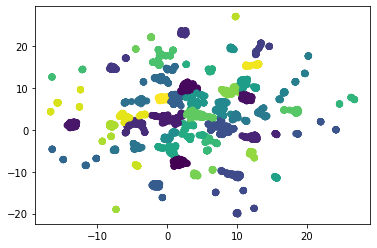

Silhouette score for the all dummy UMAP 50 cluster k-means: 0.3059062592907261
The clusters found are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


,title,rating,genre,kmean_alldummy_group,DBSCAN_alldummy_group,kmean_partialdummy_group,DBSCAN_partialdummy_group,kmean_partialdummy_UMAP_group
0,7:19,TV-MA,Dramas,1,-1,1,0,16
1,23:59,R,Horror Movies,10,-1,5,0,26
2,9,PG-13,Action & Adventure,8,0,4,0,37
3,21,PG-13,Dramas,8,1,5,0,20
4,122,TV-MA,Horror Movies,1,-1,5,0,26
...,...,...,...,...,...,...,...,...
5367,Zoom,PG,Children & Family Movies,6,17,3,3,5
5368,Zozo,TV-MA,Dramas,1,9,5,0,7
5369,Zubaan,TV-14,Dramas,3,5,1,0,0
5370,Zulu Man in Japan,TV-MA,Documentaries,12,-1,5,0,48


In [49]:
kmeans = KMeans(n_clusters=50, random_state=234)

kmeans.fit(umap_results)

kmean_y_pred = kmeans.predict(umap_results)

# Plot the solution.
plt.scatter(umap_results[:,0], umap_results[:,1], c=kmean_y_pred)
plt.show()

print("Silhouette score for the all dummy UMAP 50 cluster k-means: {}".format(
    metrics.silhouette_score(X_all_dummy, kmean_y_pred, metric='euclidean')))

print("The clusters found are: {}".format(np.unique((kmean_y_pred))))

# Adding the group predictions to a df to take a look at
kmean_y_pred_df3 = pd.DataFrame(kmean_y_pred, columns=['kmean_partialdummy_UMAP_group'])

# Adding the group predictions to a final predictions df for evaluation with the rest of the clustering methods 
movie_predictions_df = pd.concat([movie_predictions_df, kmean_y_pred_df3], axis=1)

movie_predictions_df

In [50]:
# Using the elbow method with distortion for different k values

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 56)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(umap_results)
    kmeanModel.fit(umap_results)
 
    distortions.append(sum(np.min(cdist(umap_results, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / umap_results.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(umap_results, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / umap_results.shape[0]
    mapping2[k] = kmeanModel.inertia_

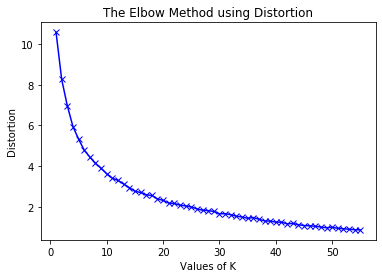

In [51]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# The below shows an elbow at ~k=10 but the silhouette scores are highest when k is closer to 50 so we will go with that.

# Performance inspection:


In [52]:
# defining function to return a list of movies (as dataframe) in any group using a given method
# method = column group name (i.e. "kmean_alldummy_group")
# group = which group number you want to look at
# length = length of the list of movies you want returned (default = 1)
def list_of_movies(method, group, length=1):
    movie_list_df = movie_predictions_df[movie_predictions_df[method]==group]
    movie_list_df = movie_list_df[['title', 'rating', 'genre', method]]
    return movie_list_df.head(length)

## KMeans methods:

In [53]:
# list for the kmeans all dummy variable method
list_of_movies('kmean_alldummy_group', 12, 1000)

# This method seems to be working quite well with a cohesive group of movies in each cluster

,title,rating,genre,kmean_alldummy_group
9,"2,215",TV-MA,Documentaries,12
21,#AnneFrank - Parallel Stories,TV-14,Documentaries,12
22,#cats_the_mewvie,TV-14,Documentaries,12
41,100 Days Of Solitude,TV-MA,Documentaries,12
72,27: Gone Too Soon,TV-MA,Documentaries,12
...,...,...,...,...
5302,XV: Beyond the Tryline,TV-14,Documentaries,12
5308,Ya no estoy aquí: Una conversación entre Guill...,TV-PG,Documentaries,12
5362,Zoé: Panoramas,TV-MA,Documentaries,12
5370,Zulu Man in Japan,TV-MA,Documentaries,12


In [54]:
# list for the kmeans partial dummy variable method
list_of_movies('kmean_partialdummy_group', 3, 1000)

# It looks like there is quite a mix of different rating levels in this method which would not be ideal in situations where we are recommending shows to kids.

,title,rating,genre,kmean_partialdummy_group
43,100 Things to do Before High School,TV-Y,Movies,3
88,48 Christmas Wishes,TV-G,Children & Family Movies,3
111,A 2nd Chance,PG,Children & Family Movies,3
113,A Babysitter's Guide to Monster Hunting,TV-PG,Children & Family Movies,3
120,A Champion Heart,G,Children & Family Movies,3
...,...,...,...,...
5344,"Yours, Mine and Ours",PG,Children & Family Movies,3
5352,Zapped,TV-Y,Children & Family Movies,3
5361,Zipi & Zape y la Isla del Capitan,TV-PG,Children & Family Movies,3
5364,Zokkomon,PG,Children & Family Movies,3


In [55]:
# list for the kmeans partial dummy UMAP variable method
list_of_movies('kmean_partialdummy_UMAP_group', 3, 1000)

# This method is producting smaller but cohesive groups but has a much larger total number of clusters (4x)

,title,rating,genre,kmean_partialdummy_UMAP_group
13,15-Aug,TV-14,Comedies,3
211,Aagey Se Right,TV-14,Comedies,3
220,Aata Pita,TV-14,Comedies,3
228,Abhinetri,TV-14,Comedies,3
249,Adhugo,TV-14,Comedies,3
...,...,...,...,...
5199,Welcome to Sajjanpur,TV-14,Comedies,3
5202,Well Done Abba,TV-14,Comedies,3
5220,What the Fish,TV-14,Comedies,3
5355,Zero,TV-14,Comedies,3


## DBSCAN methods:

In [56]:
# list for the kmeans partial dummy UMAP variable method
list_of_movies('DBSCAN_alldummy_group', -1, 4000)

# This method produces overly cohesive groups but then has a "-1" group that is catching over 3000 movies, this won't work

,title,rating,genre,DBSCAN_alldummy_group
0,7:19,TV-MA,Dramas,-1
1,23:59,R,Horror Movies,-1
4,122,TV-MA,Horror Movies,-1
6,706,TV-14,Horror Movies,-1
7,1920,TV-MA,Horror Movies,-1
...,...,...,...,...
5362,Zoé: Panoramas,TV-MA,Documentaries,-1
5363,Zodiac,R,Cult Movies,-1
5364,Zokkomon,PG,Children & Family Movies,-1
5370,Zulu Man in Japan,TV-MA,Documentaries,-1


In [57]:
# list for the kmeans partial dummy UMAP variable method
list_of_movies('DBSCAN_partialdummy_group', -1, 1000)

# This method also produces a "-1" group catching all types of movies which won't work.

,title,rating,genre,DBSCAN_partialdummy_group
23,#FriendButMarried,TV-G,Dramas,-1
24,#FriendButMarried 2,TV-G,Dramas,-1
85,37 Seconds,TV-MA,Dramas,-1
123,A Christmas Catch,TV-G,Dramas,-1
179,A Separation,PG-13,Dramas,-1
...,...,...,...,...
5265,Willy and the Guardians of the Lake: Tales fro...,TV-Y,Children & Family Movies,-1
5323,Yo-Kai Watch: The Movie,TV-Y7,Anime Features,-1
5339,Young Tiger,NR,Action & Adventure,-1
5340,Your Excellency,TV-G,Comedies,-1


# Final tool:
The goal of the final recommendation tool is for a user to input the name of the movie they just watched and assuming it is in our database we will return to them a recommendation for the same group of movies that our cluster defined. I decided to use the all dummy kmeans method because the groups that it came up with were the most inline with my goal of prioritizing rating and then also looking at genre when forming our movie groups.

In [58]:
# Asking user for the movie they just watched
print("What movie did you just watch? ")
movie_watched = input()

# Looking for that movie in our data. If we find it return the group is belongs to, if not, tell the user that we do not have a record of that movie.
if movie_watched in movie_predictions_df.title.values:
  print('We have a bunch of similar movies you might like to watch!')

  # Finding what group your movie belongs to
  group_number = movie_predictions_df.loc[movie_predictions_df['title'] == movie_watched, 'kmean_alldummy_group'].iloc[0]
  
  # Create a list of all the movies in that group but remove the movie already watched
  recommendation_df = movie_predictions_df.loc[movie_predictions_df['kmean_alldummy_group'] == group_number, 'title']
  recommendation_list = recommendation_df.tolist()
  recommendation_list.remove(movie_watched)

  # Return a random selection from the list of movies in that group
  print("Try watching {} next! ".format(recommendation_list[(random.randint(0, len(recommendation_list)))]))

else:
  print("Please make sure the movie you entered is spelled correctly as we don't have a record of {} in our data so we can't recommend you a similar movie at this time. So sorry! ".format(movie_watched))



What movie did you just watch? 
Zubaan
We have a bunch of similar movies you might like to watch!
Try watching High Strung Free Dance next! 


# Results/Summary:
As a final summary of this project, the question we were trying to answer was how can we identify similar movies based on their content. We used KMeans and DBSCAN clustering in an effort to place movies into more cohesive groups. After trying a mix of features and parameters for fitting our clusters we ultimately decided on the full dummy variable set using movie genre, rating, and country in a KMeans cluster with 13 clusters. While this method did not have the highest silhouette score, I decided to use it because, after a more manual inspection, the resulting groups were much more cohesive and appropriate. The "Final tool" found in the code cell above can be run in order to input a movie you have just viewed to find a similar movie assuming that the movie you watched is in our current data. 

A great next step for this project would be to connect more robust movie datasets and build out a much more usable front end.